In [1]:
 from google.colab import drive
 drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip '/content/drive/My Drive/ADNI/ADNI_AD_NC_2D.zip' -d 'sample_data/data/'

In [3]:
from torch.utils.data import DataLoader,SubsetRandomSampler
from torchvision import datasets, transforms
import numpy as np

In [4]:
data_dir = 'sample_data/data/AD_NC/'

transform_data = transforms.Compose([transforms.Resize((256, 256)),transforms.ToTensor()])

train = datasets.ImageFolder(data_dir + 'train',transform_data)
test= datasets.ImageFolder(data_dir + 'test',transform_data)



In [5]:
np.shape(train[0][0])

torch.Size([3, 256, 256])

In [5]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision

In [28]:
class PatchEmbedding(nn.Module):
    MIN_NUM_PATCHES = 4
    def __init__(self,
                 image_size=256,
                 patch_size=16,
                 embed_dim=768,
                 input_channels=3):
        super(PatchEmbedding, self).__init__()

        self.image_size = image_size
        self.patch_size = patch_size
        self.num_patches = 256

        self.conv = nn.Conv2d(input_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        # in = 3, out = 768 ,kernel = 16, stride = 16
        self.cls_token = nn.Parameter(torch.randn(1,1, embed_dim))
        self.positions = nn.Parameter(torch.randn((image_size // patch_size) **2 + 1, embed_dim))

    def forward(self, x):

        x = self.conv(x)
        b, c, h, w = x.shape #b,768,16,16
        x = torch.reshape(x, (b, c, h * w))# batch,768,16*16
        x = torch.transpose(x,  2, 1)#torch.Size([b, 256, 768])

        cls_tokens = self.cls_token.repeat(b,1,1) #([b, 1, 768])
        x = torch.cat([cls_tokens, x], dim=1)#([b, 257, 768])

        positions = torch.randn((256// 16) **2 + 1, 768)
        x += self.positions#([b, 257, 768])
        # print(x.size())
        return x

In [55]:

model = PatchEmbedding()

query = torch.randn([12,3, 256, 256])
m = model(query)
print ('Output size: ' + str(m.size()))

torch.Size([12, 257, 768])
Output size: torch.Size([12, 257, 768])


In [ ]:
from torchsummary import summary
summary(PatchEmbedding(),(3,256,256))

In [7]:
pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
from einops import rearrange, reduce, repeat
import math

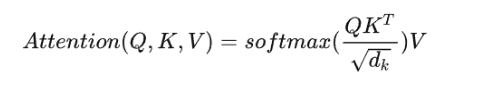

In [9]:


def scaled_dot_Attention(q, k, v, mask=None, dropout=None):
    d_k = q.size(-1)
    attn_logits = torch.matmul(q, k.transpose(-2, -1))/ math.sqrt(d_k)
    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask == 0, -1e9)
    attention = F.softmax(attn_logits, dim=-1)
    return torch.matmul(attention, v), attention

In [18]:
q = torch.randn(13,257, 768)
q = rearrange( q , "b n (h d) -> b h n d", h=12)
q.size()
d_k = q.size(-1)
d_k

64

In [10]:
class MultiHeadAttention(nn.Module):
    def __init__(self,
                 embed_dim=768,
                 num_heads=12,
                 dropout=0.0):
        super(MultiHeadAttention, self).__init__()

        self.K = nn.Linear(embed_dim,embed_dim)
        self.Q = nn.Linear(embed_dim,embed_dim)
        self.V = nn.Linear(embed_dim,embed_dim)
        self.num_heads = 12
        self.embed_dim=768
        self.d_k = 64
        self.lc = nn.Linear(embed_dim,embed_dim)




    def forward(self, x, mask=None):
        batch_size, seq_length, _embed_dim = x.size()#([b, 257, 768])
        key = self.K(x)
        key = rearrange( key, "b n (h d) -> b h n d", h=self.num_heads)
        query = self.Q(x)
        query = rearrange( query , "b n (h d) -> b h n d", h=self.num_heads)
        values = self.V(x)
        values = rearrange( values, "b n (h d) -> b h n d", h=self.num_heads)
        
        # (batch_size, head = 12, seq_length = 257, d = 64)
        values, attention = scaled_dot_Attention(query, key, values, mask=mask)
        # print(values.size())
        values = rearrange(values, "b h n d -> b n (h d)")
        # print(values.size())
        values = self.lc(values)
        # print(values.size())
        return values

In [32]:
a = torch.randn([1, 12, 257, 64])
rearrange(a, "b h n d -> b n (h d)").size()

torch.Size([1, 257, 768])

In [34]:

model = MultiHeadAttention()

query = torch.randn([1, 257, 768])
key = query
value = query

print ('Input size: ' + str(query.size()))

m = model(query)

print ('Output size: ' + str(m.size()))

Input size: torch.Size([1, 257, 768])
torch.Size([1, 12, 257, 64])
torch.Size([1, 257, 768])
torch.Size([1, 257, 768])
Output size: torch.Size([1, 257, 768])


In [11]:
class FeedForwardBlock(nn.Module):
    def __init__(self, emb_size=768, expansion = 4, drop_p = 0.0):
        super(FeedForwardBlock, self).__init__()
        self.layer_norm_1 = nn.LayerNorm(emb_size)
        self.attn = nn.MultiheadAttention(emb_size,num_heads=12,dropout=0.0)
        self.layer_norm_2 = nn.LayerNorm(emb_size)
        self.linear = nn.Sequential(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
            nn.Dropout(drop_p)
        )
        # self.lc1= nn.Linear(emb_size, expansion * emb_size)
        # self.act_1 = nn.GELU()
        # self.drop = nn.Dropout(drop_p)
        # self.lc2 = nn.Linear(expansion * emb_size, emb_size)
      
    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0]
        x = x + self.linear(self.layer_norm_2(x))
        return x

In [29]:
x = torch.randn([1, 257, 768])
patches_embedded = FeedForwardBlock()(x).size()
patches_embedded

torch.Size([1, 257, 768])

In [12]:
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 6, **kwargs):
        super().__init__(*[FeedForwardBlock(**kwargs) for _ in range(depth)])

In [ ]:
model = TransformerEncoder()

query = torch.randn([12, 257, 768])
m = model(query)
print ('Output size: ' + str(m.size()))

In [13]:
class ClassificationHead(nn.Module):
    def __init__(self, emb_size: int = 768, n_classes: int = 2):
        super().__init__()
        
        self.nrom1 = nn.LayerNorm(emb_size)
        self.lc1 = nn.Linear(emb_size, n_classes)

    def forward(self, x):
        x = reduce(x,'b n e -> b e', reduction='mean')
        x = self.nrom1(x)
        x =  self.lc1(x)
        return x

In [58]:

model = ClassificationHead()

query = torch.randn([12, 257, 768])
m = model(query)
print ('Output size: ' + str(m.size()))

Output size: torch.Size([12, 2])


In [14]:
class ViT(nn.Sequential):
    def __init__(self,     
                in_channels: int = 3,
                patch_size: int = 16,
                emb_size: int = 768,
                img_size: int = 256,
                depth: int = 12,
                n_classes: int = 2,
                **kwargs):
        super().__init__(
            PatchEmbedding(),
            TransformerEncoder(),
            ClassificationHead()
        )

In [60]:
summary(ViT(), (3, 256, 256), device='cpu')

torch.Size([2, 257, 768])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 16, 16]         590,592
    PatchEmbedding-2             [-1, 257, 768]               0
            Linear-3            [-1, 257, 3072]       2,362,368
              GELU-4            [-1, 257, 3072]               0
           Dropout-5            [-1, 257, 3072]               0
            Linear-6             [-1, 257, 768]       2,360,064
  FeedForwardBlock-7             [-1, 257, 768]               0
            Linear-8            [-1, 257, 3072]       2,362,368
              GELU-9            [-1, 257, 3072]               0
          Dropout-10            [-1, 257, 3072]               0
           Linear-11             [-1, 257, 768]       2,360,064
 FeedForwardBlock-12             [-1, 257, 768]               0
           Linear-13            [-1, 257, 3072]       2,362,368
             

In [15]:
train_loader = DataLoader(train, batch_size=64, shuffle=True)
test_loader = DataLoader(test, batch_size=64, shuffle=True)
use_cuda = torch.cuda.is_available()

In [20]:
def train_func(model, train_loader, lr = 0.0005, GPU_device = True, Epoch = 30):
    optimizer = torch.optim.Adam(model.parameters(), lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=20,gamma=0.1)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(Epoch):
        train_loss = 0.0
        for batch_idx, data in enumerate(train_loader):
            #print(batch_idx)
            inputs, target = data
            # print(target)

            if use_cuda:
                inputs = inputs.cuda()
                target = target.cuda()
                model.cuda()
                
            optimizer.zero_grad()
            output = model(inputs.float())
            _, predicted = torch.max(output.data, 1)
            # print(predicted)

            loss = criterion(predicted.float(),target.float())
            loss.requires_grad_(True)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*target.size(0)

        train_loss = train_loss / len(train_loader.dataset)
        print("epoch:",epoch+1, "train_loss:",train_loss)
              

In [31]:
model = ViT()
lr = 0.1
Epoch = 30
optimizer = torch.optim.Adam(model.parameters(), lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=20,gamma=0.1)
criterion = nn.CrossEntropyLoss()
for epoch in range(Epoch):
    train_loss = 0.0
    for batch_idx, data in enumerate(train_loader):
        #print(batch_idx)
        inputs, target = data
        # print(target)

        if use_cuda:
            inputs = inputs.cuda()
            target = target.cuda()
            model.cuda()
            
        optimizer.zero_grad()
        output = model(inputs.float())
        _, predicted = torch.max(output.data, 1)
        # print(predicted)

        loss = criterion(predicted.float(),target.float())
        loss.requires_grad_(True)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*target.size(0)

    train_loss = train_loss / len(train_loader.dataset)
    print("epoch:",epoch+1, "train_loss:",train_loss)

epoch: 1 train_loss: 137.43887584785546


KeyboardInterrupt: ignored